## Spatial statistics and generalised interpolation

Notebook investigating multidimensional interpolation, including Radial Basis Functions (RBF) and Kriging examples.

The calculations are performed within this notebook. The numpy python library is used for the underlying linear algebra of matrix inversion and multiplication, and the method-specific steps are coded within this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

### Linear weighting

Consider the real function $f(X)$ where $X$ is a vector in an m-dimensional space. Take also a set of points $X_i$ with $i$ running from $1$ to $N$. We can form the vector $F$ with $F_i = f(X_i)$.

Define the estimated function $g(X) = \sum_{i=1}^N W_i(X) F_i = W(X).F$, where $W(X)$ is a vector of weights; in general these weights are a function of $X$. One-dimensional linear interpolation, for example, corresponds to the case where $m=1$ and the weights are determined by distances to the nearest neighbour(s).

Two cases of interest are RBF and Kriging. The general approach is to define the function $f(X)$, then a procedure for preparing the values needed to pass to a weight generating function that determines $W(X)$; in other words precalculation of the parameters used within $W(X)$ is desirable for efficiency. 

### RBF

Radial basis functions are based around a kernel function $k(A,B)$ that represents some idea of the distance between points $A$ and $B$. In general the kernel function is symmetric, so $k(A,B) = k(B,A)$, and also translationally invariant, so $k(A,B) = \phi(A-B)$.

Consider the function $h(X) = \sum_i k(X,X_i) \alpha_i$ for a vector $\alpha$ of factors, one for each point $X_i$. Then we can form $H$ according to $H_i = h(X_i)$, and then find the factors $\alpha$ that minimize the regularized
likelihood $L = \frac{1}{2}\left(F-H\right)^2 + \frac{\lambda}{2}\left(\alpha K \alpha\right)$, where the matrix $K$ has been formed as $K_{ij} = k(X_i,X_j)$, so $H = K.\alpha$.

Minimizing the likelihood yields $\alpha = \left(K-\lambda\right)^{-1} F$. Note that this means that the estimated function is of the linear weighting form described above.

In [2]:
def simple_kernel(a,b):
    diff = a-b
    len2 = np.dot(diff,diff)
    return 1.0/(1.0+0.5*len2)

In [3]:
def function(x):
    return x[1]*x[0] + np.log(x[0]+0.001)+x[2]*x[2]*x[2]

In [4]:
test_points = pd.DataFrame([[1,2,3],
                           [4,5,6],
                           [0,1,0],
                           [1,0,0]])
test_points

,0,1,2
0,1,2,3
1,4,5,6
2,0,1,0
3,1,0,0


In [5]:
def form_rbf_artifacts(function, kernel, points, lambd = 0):
    # Form the F vector
    pointValues = points.apply(function,axis=1)
    numPoints = len(points)
    # Form the kernel matrix K
    cMat = np.zeros(shape=(numPoints,numPoints))
    for i in range(numPoints):
        iRow = np.array(points.iloc[i])
        for j in range(i,numPoints):
            cMat[i,j] = kernel(iRow,points.iloc[j])
            cMat[j,i] = cMat[i,j]
    resolv = cMat - (lambd*np.identity(numPoints))
    resInv = np.linalg.inv(resolv)
    alpha = np.matmul(resInv, pointValues)
    def points_estimator(x,kernel,points,**kwargs):
        return points.apply(lambda pointsRow: kernel(x,pointsRow),axis=1)
    def estimator(x,alpha,**kwargs):
        kVec = points_estimator(x,**kwargs)
        return np.dot(kVec,alpha)
        
    return estimator , {
        'kernel':kernel,
        'function':function,
        'pointValues':pointValues,
        'points':points,
        'lambda':lambd,
        'alpha':alpha,
        'resInv':resInv,
        'points_estimator':points_estimator,
    }

In [6]:
estimator, kwargs = form_rbf_artifacts(function, simple_kernel, test_points)

In [7]:
print(estimator(np.array([3,4,5]),**kwargs))
print(estimator([1,2,3],**kwargs))
print(estimator(test_points.iloc[0],**kwargs))
test_points.apply(estimator,axis=1,**kwargs)-kwargs['pointValues']

96.1636872756
29.0009995003
29.0009995003


0   -3.552714e-15
1    5.684342e-14
2   -8.881784e-16
3   -2.645453e-16
dtype: float64

## Kriging

This is another weighted sum approach. In this method, the weights are chosen to minimize the expected variance of the predicted value. Specifically, given an $N$-dimensional vector of ones, $U$, we require that the weights $\beta$ be
normalised so $U.\beta = 1$ and the weights are chosen for a given $X$ to minimize the variance of the estimated
value $g(X) = \beta(X).F$ by leveraging the covariance function $c(X,Y)$.

Defining $C$ as the matrix formed using $C_{ij} = c(X_i,X_j)$ and the point covariance vector $D(X)$ as $D_i = c(X,X_i)$, the variance at $X$ is given
by $\sigma^2 = c(X,X) + \beta C \beta - 2 \beta D$.

Minimizing this variance with the constraint on the sum of the
$\beta$ values gives $\beta = C^{-1}(D - \lambda U)$ where $\lambda = \frac{(U C^{-1} D - 1)}{U C^{-1} U}$ is the Lagrange parameter introduced with the constraint.

In [8]:
def form_kriging_artifacts(function, covariance, points):
    # Determine C and its inverse
    pointValues = points.apply(function,axis=1)
    numPoints = len(points)
    # Form the kernel matrix K
    unit_vec = np.ones(numPoints)
    cMat = np.zeros(shape=(numPoints,numPoints))
    for i in range(numPoints):
        iRow = np.array(points.iloc[i])
        for j in range(i,numPoints):
            cMat[i,j] = covariance(iRow,points.iloc[j])
            cMat[j,i] = cMat[i,j]
    cInv = np.linalg.inv(cMat)
    lambda_factor = 1.0 / (np.dot(unit_vec,np.dot(cInv,unit_vec)))
    def estimator(x,points,covariance,unit_vec,cInv,lambda_factor,pointValues,**kwargs):
        dVec = points.apply(covariance,axis=1,y=x)
        lTop = np.dot(unit_vec,np.dot(cInv,dVec)) - 1.0
        lambdaVal = lTop * lambda_factor
        beta = np.matmul(cInv,dVec - lambdaVal * unit_vec)
        return np.matmul(beta,pointValues)
    return estimator, {
        'function':function,
        'covariance':covariance,
        'pointValues':pointValues,
        'points':points,
        'cMatrix':cMat,
        'cInv':cInv,
        'unit_vec':unit_vec,
        'lambda_factor':lambda_factor,
    }


In [9]:
def covariance(x,y):
    diff = x - y
    dist = np.dot(diff,diff)/50
    return 1 - np.tanh(dist)


In [10]:
estimator, kwargs = form_kriging_artifacts(function,covariance,test_points)

In [11]:
print(estimator(np.array([3,4,5]),**kwargs))
print(estimator([1,2,3],**kwargs))
print(estimator(test_points.iloc[0],**kwargs))
test_points.apply(estimator,axis=1,**kwargs)-kwargs['pointValues']

170.496536374
29.0009995003
29.0009995003


0    2.486900e-14
1    8.526513e-14
2   -8.881784e-16
3   -4.078205e-14
dtype: float64

## One dimensional test function

We use $f(x) = x^3 - 5$ as a simple test function, and compare RBF and Kriging. We use both regularized and unregularized RBF estimation. A limited range from $-2$ to $+2$ is used for the $9$ base points.

In [12]:
func1D = lambda x: (x*x*x -5)

In [13]:
func1DEst, kwargs = form_rbf_artifacts(func1D, simple_kernel, pd.DataFrame([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]))
func1DReg, krargs = form_rbf_artifacts(func1D, simple_kernel, pd.DataFrame([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]),lambd=-0.5)
func1DKre, krawgs = form_kriging_artifacts(func1D, covariance, pd.DataFrame([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]))


In [14]:
xVec = np.arange(-400,400) / 20

In [15]:
vals = [func1DEst(x,**kwargs) for x in xVec]
actVals = [func1D(x) for x in xVec]
kals = [func1DKre(x,**krawgs) for x in xVec]
rals = [func1DReg(x,**krargs) for x in xVec]

ratio = [v/a for v,a in zip(vals,actVals)]
rario = [v/a for v,a in zip(rals,actVals)]
katio = [v/a for v,a in zip(kals,actVals)]


Text(0.5,0.98,'One-dimensional function estimation')

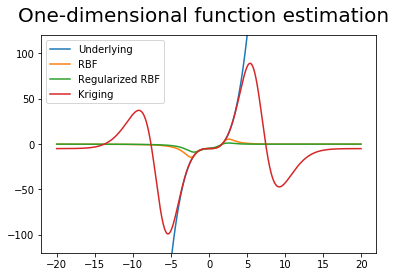

In [16]:
plt.plot(xVec,actVals,label="Underlying")
plt.plot(xVec,vals,label="RBF")
plt.plot(xVec,rals,label="Regularized RBF")
plt.plot(xVec,kals,label="Kriging")

axes = plt.gca()
axes.set_ylim([-120,120])

plt.legend()
plt.suptitle("One-dimensional function estimation",fontsize=20)

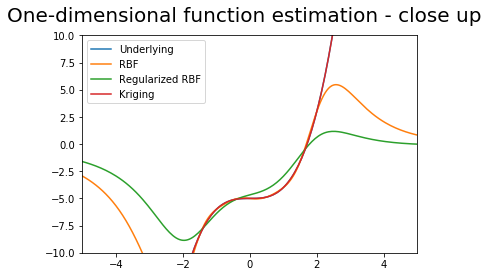

In [20]:
plt.plot(xVec,actVals,label="Underlying")
plt.plot(xVec,vals,label="RBF")
plt.plot(xVec,rals,label="Regularized RBF")
plt.plot(xVec,kals,label="Kriging")

axes = plt.gca()
axes.set_xlim([-5,5])
axes.set_ylim([-10,10])
plt.suptitle("One-dimensional function estimation - close up",fontsize=20)
plt.legend()

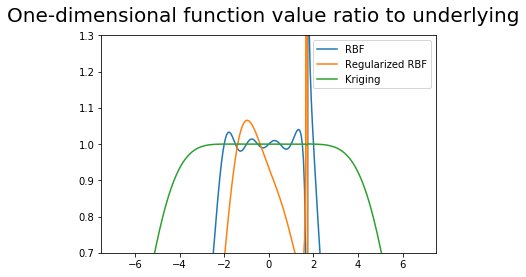

In [21]:
plt.plot(xVec,ratio,label="RBF")
plt.plot(xVec,rario,label="Regularized RBF")
plt.plot(xVec,katio,label="Kriging")
axes = plt.gca()
axes.set_ylim([0.7,1.3])
axes.set_xlim([-7.5,7.5])
plt.suptitle("One-dimensional function value ratio to underlying",fontsize=20)
plt.legend()

In [19]:
resInv = kwargs['resInv']
for x in [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,0.99,0.9,0.75,5]:
    p = np.matmul(kwargs['points_estimator'](x,**kwargs),resInv)
    print(p)
                 

[  1.00000000e+00   5.30363468e-16  -6.21487844e-15  -3.05265211e-15
   3.64292516e-15   5.48367390e-15   5.81679354e-16   9.87054569e-16
   1.76926232e-17]
[  1.49218227e-15   1.00000000e+00  -2.26127633e-15   2.66511783e-15
   7.88916753e-17   2.46248076e-15   6.76501688e-15   5.47768400e-17
   5.71616810e-16]
[  2.44591048e-15   8.89384631e-18   1.00000000e+00  -5.80721204e-16
   3.35778904e-15  -2.42768322e-15   3.50069754e-15  -1.17093582e-15
   7.92959144e-16]
[  1.93125931e-15   8.44525730e-16   4.40802729e-15   1.00000000e+00
  -1.37012254e-15  -5.45735700e-15  -1.84571169e-15  -6.73069339e-16
   2.10707028e-17]
[  1.93314487e-16   4.74134824e-15  -4.10071371e-15   5.83005450e-15
   1.00000000e+00   4.46061303e-15  -1.26878613e-14   6.51387739e-15
  -1.94532357e-15]
[ -1.00117736e-15   4.15182666e-15  -7.86048137e-15   1.27288688e-14
  -6.01723932e-15   1.00000000e+00  -1.11655297e-14   3.97088081e-15
  -2.25395847e-15]
[  3.44995612e-16   9.33979183e-16   2.67875823e-15  -2.99